# PROPHET

### IMPORT DE DEPENDENCIAS

A printcipal dependencia  Prophet é uma dependencia baseada no PyStan (Uma Lib que funciona de interface para o uso da biblioteca statistica STAN).

#### A instalação do PyStan no Windows (Utilizando Conda) [Tutorial](https://pystan2.readthedocs.io/en/latest/windows.html#installing-c-compiler)

Antes da instalação da biblioteca PyStan é necessario instalar as dependências:

 - Python: 2.7, >=3.3
 - Cython: >=0.22
 - NumPy: >=1.7

Apos isso é necessario instalar o interpretador C++. A forma mais facil de instalar é atravez do [Miniconda3 Windows 64-bit](https://repo.anaconda.com/miniconda/Miniconda3-latest-Windows-x86_64.exe). Apos a instalação desse pacote rodar o comando para instalar algumas libs: 

`conda install libpython m2w64-toolchain -c msys2`<br>

Em seguida é necessario a criação de o arquivo `distutils.cfg` na pasta `PYTHONPATH\\Lib\\distutils` com o seguinte texto:

`[build]`<br>
`compiler=mingw32`

Apos a criação é possivel instalar a biblioteca PyStan:

`pip install pystan==2.19.1.1`

Em seguida pode instalar a biblioteca prophet

`conda config --add channels conda-forge`<br>
`conda install prophet`



### IMPORT DE BIBLIOTECA

In [156]:
#Import bibliotecas 
import sys
import logging
import itertools
import numpy as np
import pandas as pd
import logging, sys
import seaborn as sns
from prophet import Prophet
logging.disable(sys.maxsize)
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
logging.getLogger('fbprophet').setLevel(logging.ERROR) 

### IMPORT DE DATASET

In [123]:
df_fb = pd.read_csv("./data/FB Historical Data.csv") #Importando os dados historicos
df_fb["Date"] = pd.to_datetime(df_fb["Date"], format="%b %d, %Y") #Convertendo coluna data de STRING para DATETIME

# PREVISÃO DE DADOS - UNIVARIAVEL

### SEPARANDO DADOS

In [124]:
df_uni = df_fb[['Date','Price']] #Selecionando os campos a serem utilizados  
df_uni.columns = ['ds','y'] #Alterando os nomes da colunas para o valor padrão exigido pelo modelo
df_uni = df_uni.sort_values(by="ds").reset_index(drop=True) #Organizando os valores por data e reindexando o dataset

### SEPARAÇÃO DOS DADOS DE TREINO E TESTE

In [125]:
#Separando o dataset entre treino e teste
train_uni = df_uni[:len(df_uni)-24]
test_uni = df_uni[len(df_uni)-24:]

### CONFIGURAÇÃO DE GRID DE PARAMETROS

In [126]:
# Criação de dicionario de parametros
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5,1],
    'seasonality_prior_scale': [0.01, 0.1, 0.5,1],
    'seasonality_mode': ['multiplicative','additive'],
    'yearly_seasonality': [True,False],
    'weekly_seasonality': [True,False]
}

# Gerando todas combinações de parametros
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Armazenando os resultados de erro
size_params = len(all_params) # Tamanho total da lista de parametros 
i=0 #Contador da porcentagem

### CRIAÇÃO DE MODELOS UNIVARIAVEL E TESTE DE RMSE

In [127]:
# Recursão que roda o modelo e faz a previsão para cada combinação de parametro
for params in all_params:
    i = i+1
    m = Prophet(**params).fit(train_uni) # Treina o modelo com os parametros com os dados de treino
    forecast = m.predict(df_uni[["ds"]]) # Prevendo os valores para as datas futuras 
    prev = forecast[['ds', 'yhat',]].tail(24) # Selecionando os valores previstos
    # Comparando valores previstos com o valor real e obtendo o erro
    rmses.append(mean_squared_error(prev["yhat"].reset_index(drop=True),test_uni["y"].reset_index(drop=True)))
    percent = int((i/size_params)*100) #percentual ja rodado
    sys.stdout.write('\r'+"[{}{}] {}%".format("="*percent," "*(100-percent),percent)) #Exibindo o percentual do processo finalizado

tuning_results_uni = pd.DataFrame(all_params) #Criação de dataframe de resultados
tuning_results_uni['rmse'] = rmses #Adicionando os erros ao dataframe de resultados

[====================================================================================================] 100%

### APRESENTAÇÃO DE RESULTADO DE MODELOS UNIVARIAVEL

In [128]:
# 10 Melhores combinações de modelo 
tuning_results_uni.sort_values(by="rmse").reset_index(drop=True).head(10)

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,yearly_seasonality,weekly_seasonality,rmse
0,0.5,0.1,additive,True,False,22.827442
1,1.0,1.0,additive,True,False,22.924209
2,1.0,0.5,additive,True,True,24.512801
3,1.0,0.1,additive,True,False,24.774044
4,1.0,1.0,multiplicative,True,True,25.371197
5,0.5,1.0,additive,True,True,26.172960
6,0.5,0.1,additive,True,True,26.795878
7,1.0,0.5,additive,True,False,29.143747
8,1.0,0.1,additive,True,True,29.893665
9,1.0,1.0,additive,True,True,32.960096


# PREVISÃO DE DADOS - MULTIVARIAVEL

### SEPARANDO DADOS MULTIVARIAVEIS

In [160]:
df_multi = df_fb[['Date', 'Price', 'Open', 'High', 'Low']]
df_multi.columns = ['ds', 'y', 'Open', 'High', 'Low']
df_multi = df_multi[['ds', 'y', 'Open', 'High', 'Low']].sort_values(by="ds").reset_index(drop=True)

### ATRASANDO VARIAVEIS PARA UTILIZAÇÃO COM FEATURES DO MODELO

In [161]:
df_multi['Open_shift'] = df_multi['Open'].shift(1)
df_multi['High_shift'] = df_multi['High'].shift(1)
df_multi['Low_shift'] = df_multi['Low'].shift(1)


### DATASET DEPOIS DO ATRASO

In [164]:
df_multi.head(10)

,ds,y,Open,High,Low,Open_shift,High_shift,Low_shift
0,2019-01-02,135.68,128.99,137.51,128.56,NaN,NaN,NaN
1,2019-01-03,131.74,134.69,137.17,131.12,128.99,137.51,128.56
2,2019-01-04,137.95,134.01,138.00,133.75,134.69,137.17,131.12
3,2019-01-07,138.05,137.56,138.87,135.91,134.01,138.00,133.75
4,2019-01-08,142.53,139.89,143.14,139.54,137.56,138.87,135.91
5,2019-01-09,144.23,142.95,144.70,141.27,139.89,143.14,139.54
6,2019-01-10,144.20,143.08,144.56,140.84,142.95,144.70,141.27
7,2019-01-11,143.80,143.15,145.36,142.57,143.08,144.56,140.84
8,2019-01-14,145.39,142.00,146.57,141.27,143.15,145.36,142.57
9,2019-01-15,148.95,146.01,150.68,145.99,142.00,146.57,141.27


### SELECIONADO COLUNAS PARA O MODELO

In [ ]:
df_multi = df_multi.dropna().reset_index(drop=True)
df_multi = df_multi[['ds', 'y', 'Open_shift', 'High_shift', 'Low_shift']]

### SEPARAÇÃO DOS DADOS DE TREINO E TESTE

In [131]:
train_multi = df_multi[:len(df_multi)-24] 
test_multi = df_multi[len(df_multi)-24:]

### CONFIGURAÇÃO DE GRID DE PARAMETROS

In [132]:
# Criação de dicionario de parametros
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5,1],
    'seasonality_prior_scale': [0.01, 0.1, 0.5,1],
    'seasonality_mode': ['multiplicative','additive'],
    'yearly_seasonality': [True,False],
    'weekly_seasonality': [True,False]
}

# Gerando todas combinações de parametros
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Armazenando os resultados de erro
size_params = len(all_params) # Tamanho total da lista de parametros 
i=0 #Contador da porcentagem

### CRIAÇÃO DE MODELOS MULTIVARIAVEIS E TESTE DE RMSE

In [ ]:
# Recursão que roda o modelo e faz a previsão para cada combinação de parametro
for params in all_params:
    i = i+1
    m = Prophet(**params)
    m.add_regressor("Open_shift")
    m.add_regressor("High_shift")
    m.add_regressor("Low_shift")
    m.fit(train_multi) # Treina o modelo com os parametros com os dados de treino
    forecast = m.predict(df_multi[["ds",'Open_shift','High_shift','Low_shift']]) # Prevendo os valores para as datas futuras 
    prev_multi = forecast[['ds', 'yhat',]].tail(24) # Selecionando os valores previstos
    # Comparando valores previstos com o valor real e obtendo o erro
    rmses.append(mean_squared_error(prev_multi["yhat"].reset_index(drop=True),test_multi["y"].reset_index(drop=True)))
    percent = int((i/size_params)*100) #percentual ja rodado
    sys.stdout.write('\r'+"[{}{}] {}%".format("="*percent," "*(100-percent),percent)) #Exibindo o percentual do processo finalizado

tuning_results_multi = pd.DataFrame(all_params) #Criação de dataframe de resultados
tuning_results_multi['rmse'] = rmses #Adicionando os erros ao dataframe de resultados

### APRESENTAÇÃO DE RESULTADO DE MODELOS MULTIVARIAVEL

In [142]:
# 10 Melhores combinações de modelos Multivariavel
tuning_results_multi.sort_values(by="rmse").reset_index(drop=True).head(10)

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,yearly_seasonality,weekly_seasonality,rmse
0,0.1,0.01,additive,True,False,14.361732
1,0.1,0.10,additive,True,False,14.381641
2,0.1,1.00,additive,True,False,14.419311
3,0.1,0.50,additive,True,False,14.430338
4,0.1,0.10,additive,True,True,14.458898
5,0.1,0.01,additive,True,True,14.494070
6,0.1,1.00,additive,True,True,14.513579
7,0.1,0.50,additive,True,True,14.516945
8,0.1,0.10,multiplicative,True,False,14.710603
9,0.1,1.00,multiplicative,True,False,14.715370


# RESULTADOS

## Comparação de resultados de melhores modelos.

### MODELO UNIVARIAVEL COM MELHORES PARAMETROS

In [143]:
m = Prophet(changepoint_prior_scale=0.5,
    seasonality_prior_scale= 0.01,seasonality_mode= 'additive', yearly_seasonality= False).fit(train_uni)
forecast = m.predict(df_uni[["ds"]]) # Prevendo os valores para as datas futuras
prev_uni = forecast[['ds', 'yhat',]].tail(24) # Selecionando os valores previstos

### MODELO MULTIVARIAVEL COM MELHORES PARAMETROS

In [144]:
m = Prophet(changepoint_prior_scale=0.1,
    seasonality_prior_scale= 0.1, seasonality_mode = 'additive', 
    yearly_seasonality= True, weekly_seasonality=False)
m.add_regressor("Open_shift")
m.add_regressor("High_shift")
m.add_regressor("Low_shift")
m.fit(train_multi) # Treina o modelo com os parametros com os dados de treino
forecast = m.predict(df_multi[["ds",'Open_shift','High_shift','Low_shift']]) # Prevendo os valores para as datas futuras
prev_multi = forecast[['ds', 'yhat',]].tail(24) # Selecionando os valores previstos

## PLOT DE PREVISÃO

<AxesSubplot:xlabel='ds', ylabel='yhat'>

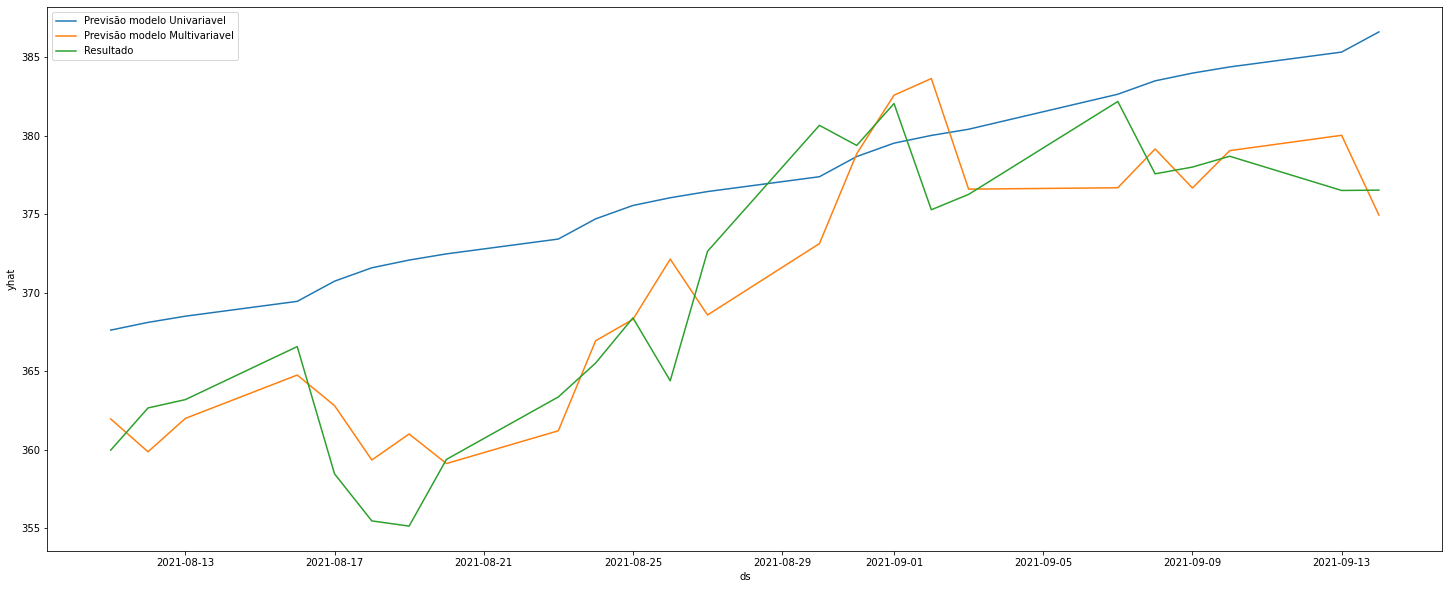

In [155]:
fig,ax = plt.subplots(figsize=(25,10))
sns.lineplot(x=prev_uni['ds'],y=prev_uni["yhat"],label="Previsão modelo Univariavel")
sns.lineplot(x=prev_multi['ds'],y=prev_multi["yhat"],label="Previsão modelo Multivariavel")
sns.lineplot(x=test_multi['ds'],y=test_multi["y"],label="Resultado")